# Final Notebook
# Created by: [Aaron Ooi, Viet Nguyen, Trevor Mathisen]

# Part 1: EDA

In [1]:
final_models = [] # Add your final models here as a tuple of ('name', model)) for Part 3

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import ndarray, argsort

from pandas import set_option, read_csv, DataFrame, concat
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score

In [3]:
DONT_RUN_LONG_CELLS = True
kickstarter_filename = 'kickstarter_data_full.csv'
kickstarter_filename_features = 'kickstarter_data_with_features.csv'

ks_data = read_csv(kickstarter_filename)
ks_feat_data = read_csv(kickstarter_filename_features)
data_list = [('ks_data', ks_data), ('ks_feat_data', ks_feat_data)]

/tmp/ipykernel_4412/1756175993.py:5: DtypeWarning: Columns (29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  ks_data = read_csv(kickstarter_filename)
/tmp/ipykernel_4412/1756175993.py:6: DtypeWarning: Columns (29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  ks_feat_data = read_csv(kickstarter_filename_features)


### Determine if the two datasets are the same

In [4]:
# print columns not present in the other dataset
ks_data_columns = set(ks_data.columns)
ks_feat_data_columns = set(ks_feat_data.columns)

ks_data_not_in_feat = ks_data_columns - ks_feat_data_columns
ks_feat_data_not_in_ks = ks_feat_data_columns - ks_data_columns

print(f'Columns in ks_data not in ks_feat_data: {ks_data_not_in_feat}')
print(f'Columns in ks_feat_data not in ks_data: {ks_feat_data_not_in_ks}')

common_columns = ks_data_columns.intersection(ks_feat_data_columns)

# of common columns, compare the values and see if they match
for column in common_columns:
    ks_data_values = ks_data[column].unique()
    ks_feat_data_values = ks_feat_data[column].unique()
    if len(ks_data_values) != len(ks_feat_data_values):
        print(f'Column {column} has different number of unique values: {len(ks_data_values)} vs {len(ks_feat_data_values)}')
    else:
        pass

Columns in ks_data not in ks_feat_data: {'create_to_launch_days', 'LaunchedTuesday', 'DeadlineWeekend', 'SuccessfulBool', 'USorGB', 'launch_to_deadline_days', 'TOPCOUNTRY', 'launch_to_state_change_days'}
Columns in ks_feat_data not in ks_data: set()
Column launch_to_state_change has different number of unique values: 7544 vs 2477


## So we know ks_data is the dataset to use as it has more data, more unique data


In [5]:
data_list = [('ks_data', ks_data), ('ks_feat_data', ks_feat_data)]

def data_info(_data, show_scatter=False):
    print(f'Data head: {_data.head(5)}')
    print(f'Null values: {_data.isnull().sum()}')
    print(f'Data Shape: {_data.shape[0]} rows and {_data.shape[1]} columns')
    print(f'Columns: {list(_data.columns)}')
    for column in _data.columns:
        if len(_data[column].unique()) < 10:
            print(f'{column} unique values: {_data[column].unique()}')
        else:
            percent_unique = len(_data[column].unique()) / _data.shape[0] * 100
            print(f'{column} % unique values: {percent_unique}')
    print(_data.describe())
    _data.hist(figsize=(12, 10))
    plt.tight_layout()
    plt.show()
    plt.figure()  # new plot
    plt.tight_layout()

    # Only show for floats and ints

    float_columns = _data.select_dtypes(include=['float64']).columns
    int_columns = _data.select_dtypes(include=['int64']).columns
    # Combine float and int columns

    numeric_columns = float_columns.append(int_columns)
    # Calculate correlation matrix
    corMat = _data[numeric_columns].corr(method='pearson')

    print(corMat)
    ## plot correlation matrix as a heat map
    plt.figure(figsize=(14, 10))
    sns.heatmap(corMat, square=True)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.title(f"CORRELATION MATRIX USING HEAT MAP")
    plt.show()

    ## scatter plot of all _data
    plt.figure()
    # # The output overlaps itself, resize it to display better (w padding)
    if show_scatter:
        try:
            scatter_matrix(_data)
            plt.tight_layout(pad=0.1)
            plt.show()
        except:
            return


def data_info_less(_date):
    set_option('display.max_columns', None)
    if not isinstance(_date, list):
        if not isinstance(_date, tuple):
            _date = ('', _date)
        _date = [_date]
    for name, data in _date:
        print(f'{name} data')
        print(data.info())
        print(data.head(5))
        for column in data.columns:
            highlight_column = 'profile'
            if column == highlight_column:
                # print 2 rows of values completely
                row1 = data.iloc[0][highlight_column]
                row2 = data.iloc[1][highlight_column]
                print(f'Row 1: {row1}')
                print(f'Row 2: {row2}')
            if len(data[column].unique()) < 10:
                print(f'{column} unique values: {data[column].unique()}')
            else:
                percent_unique = len(data[column].unique()) / data.shape[0] * 100
                print(f'{column} % unique values: {percent_unique}')
        break

Data head:    Unnamed: 0          id                                              photo  \
0           0  1454391034  {"small":"https://ksr-ugc.imgix.net/assets/011...   
1           1  1655206086  {"small":"https://ksr-ugc.imgix.net/assets/012...   
2           2   311581827  {"small":"https://ksr-ugc.imgix.net/assets/012...   
3           3   859724515  {"small":"https://ksr-ugc.imgix.net/assets/011...   
4           4  1613604977  {"small":"https://ksr-ugc.imgix.net/assets/012...   

                                                name  \
0  Auntie Di's Music Time Sign ASL for Hearing an...   
1                    Jump Start Kindergarten Toolkit   
2  Ojukwu Balewa Awolowo (O.B.A.) Public Library ...   
3      MASTIZE - [mas-TAHYZ, MAS-tahyz]  - to spread   
4  Synopse der EU-DSGVO - Artikel, Erwägungsgründ...   

                                               blurb      goal  pledged  \
0  MTS ASL Curriculum Workbook is a reproducible ...    1500.0      0.0   
1  This kit teaches h

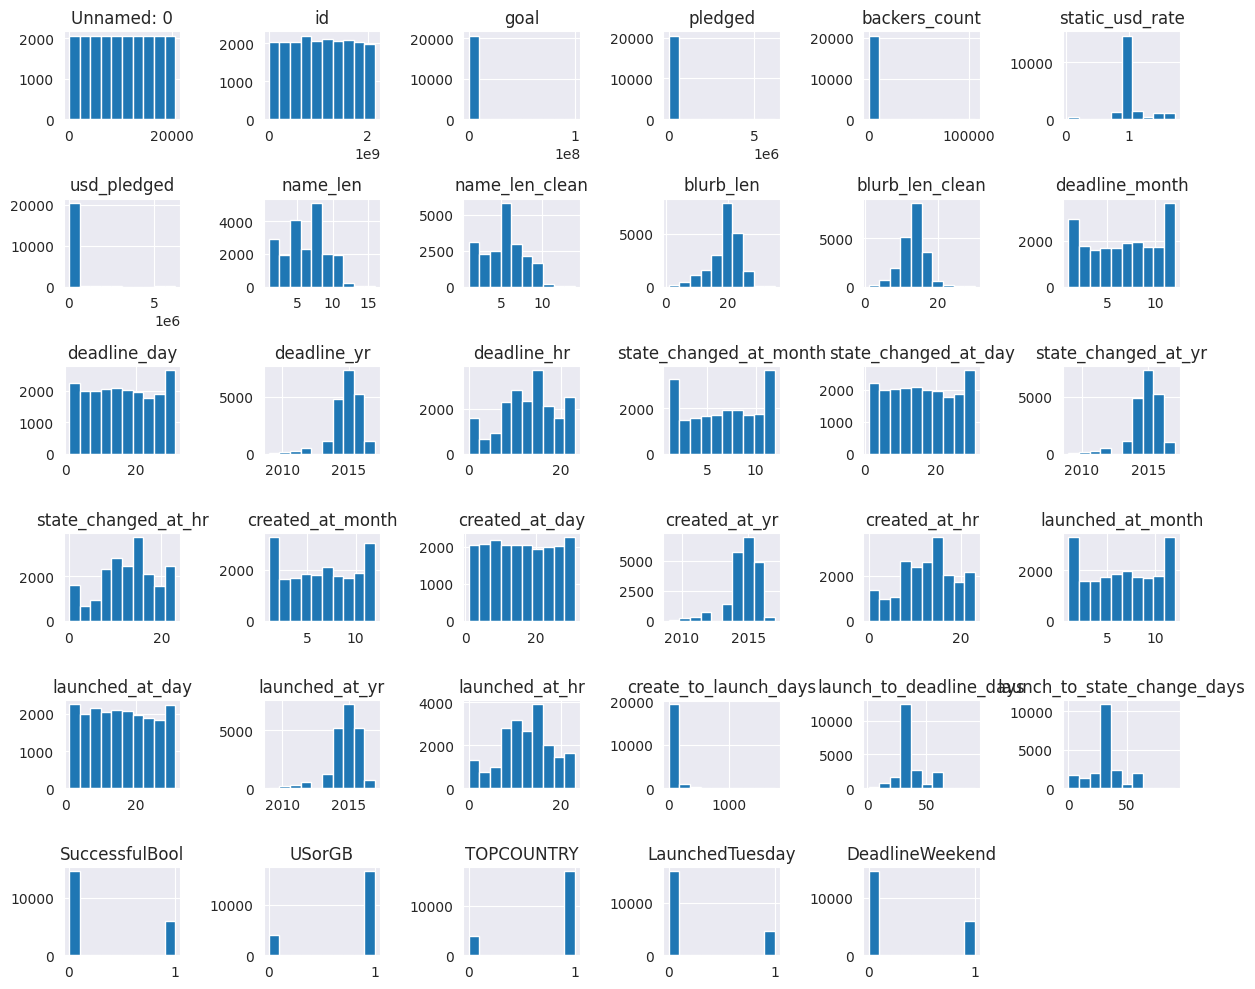

                                 goal   pledged  static_usd_rate  usd_pledged  \
goal                         1.000000  0.010058        -0.032784     0.009606   
pledged                      0.010058  1.000000        -0.047503     0.951005   
static_usd_rate             -0.032784 -0.047503         1.000000    -0.003084   
usd_pledged                  0.009606  0.951005        -0.003084     1.000000   
name_len                    -0.015942  0.085350        -0.001388     0.086470   
name_len_clean              -0.014563  0.090141        -0.015156     0.090229   
blurb_len                   -0.009151 -0.001119         0.042769     0.000770   
blurb_len_clean             -0.008069  0.012587         0.028186     0.014366   
Unnamed: 0                   0.001723  0.047542        -0.094229     0.046125   
id                           0.009464  0.004588        -0.002334     0.002065   
backers_count                0.003838  0.724279        -0.003737     0.758001   
deadline_month              

<Figure size 640x480 with 0 Axes>

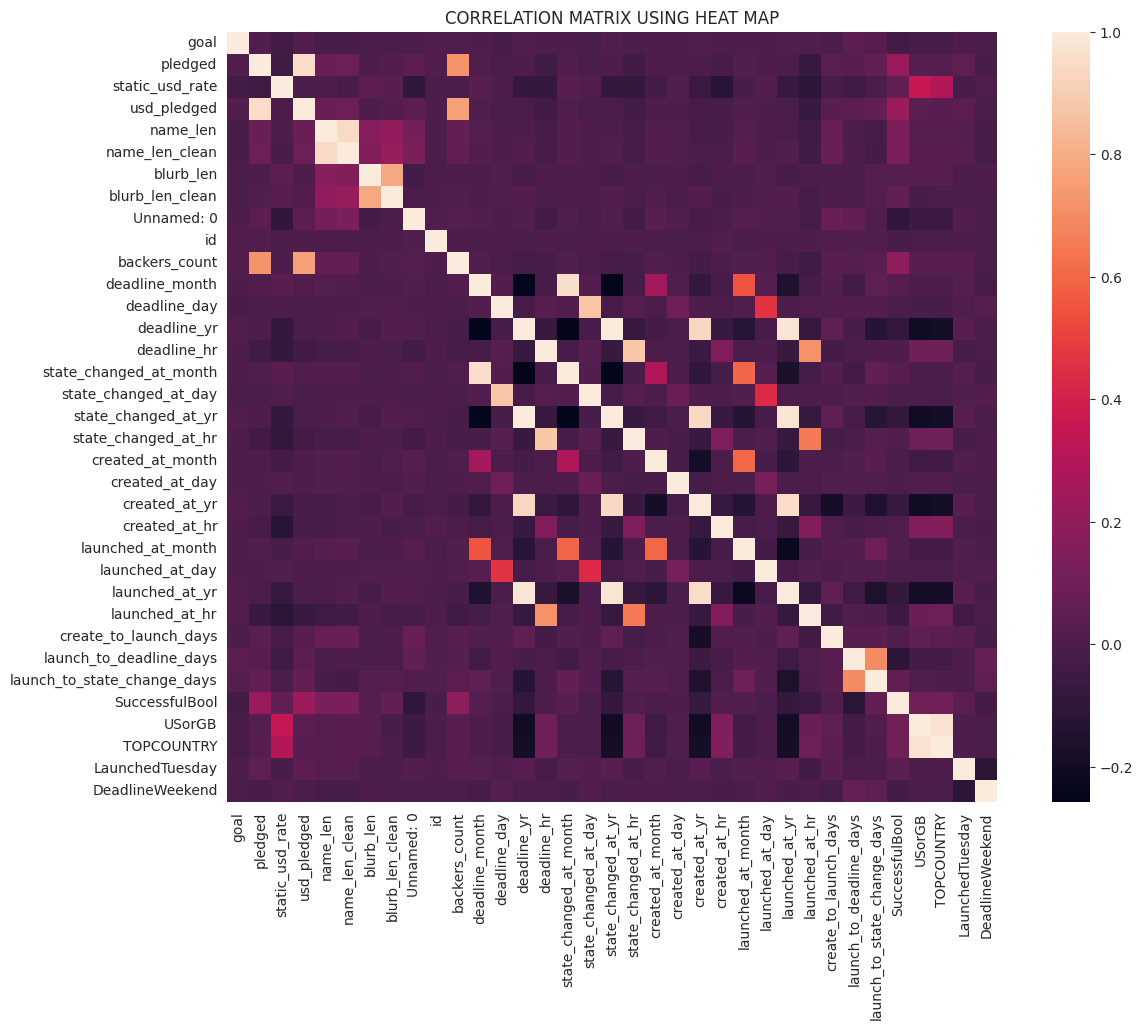

<Figure size 640x480 with 0 Axes>

In [6]:
data_info(ks_data)


### By iteratively looking at columns in this cell, and looking at just those not categorized by a human, we can determine what columns are not needed, and types of others

### We also determine unique columns and their values to setup for one-hot encoding later

In [7]:
columns_to_drop = ['Unnamed: 0', 'id', 'photo', 'name', 'blurb', 'slug', 'currency_symbol', 'currency_trailing_code', 'static_usd_rate', 'creator', 'profile', 'friends', 'is_backing', 'permissions', 'name_len', 'blurb_len', 'urls', 'source_url', 'location', 'is_starred', 'create_to_launch']
float_columns = ['goal', 'pledged', 'usd_pledged']
int_columns = ['backers_count', 'name_len_clean', 'blurb_len_clean',  'launch_to_deadline', 'launch_to_state_change', 'create_to_launch_days', 'launch_to_deadline_days', 'launch_to_state_change_days', ]
datetime_columns = ['deadline', 'state_changed_at', 'created_at', 'launched_at']
date_int_columns = ['deadline_month', 'deadline_day', 'deadline_hr', 'state_changed_at_month', 'state_changed_at_day', 'state_changed_at_month', 'state_changed_at_day', 'state_changed_at_yr', 'created_at_month', 'created_at_day', 'created_at_hr', 'launched_at_month', 'launched_at_day', 'launched_at_hr', 'state_changed_at_hr', 'created_at_yr', 'launched_at_yr']
category_columns = ['state', 'currency', 'staff_pick', 'category', 'deadline_weekday', 'state_changed_at_weekday', 'created_at_weekday', 'launched_at_weekday', 'deadline_yr', 'country']
boolean_columns = ['disable_communication', 'spotlight', 'SuccessfulBool', 'USorGB', 'TOPCOUNTRY', 'LaunchedTuesday', 'DeadlineWeekend']

# This is just to categorize everything and make sure I'm not missing anything
temp_data = ks_data.copy()
data_info_less(temp_data)
temp_data = temp_data.drop(columns=columns_to_drop)
temp_data = temp_data.drop(columns=datetime_columns)
temp_data = temp_data.drop(columns=category_columns)
temp_data = temp_data.drop(columns=boolean_columns)
temp_data = temp_data.drop(columns=float_columns)
temp_data = temp_data.drop(columns=int_columns)
temp_data = temp_data.drop(columns=date_int_columns)
print('\n' * 3)
print(f'Lets see what we have left')
data_info_less(('temp_data', temp_data))

 data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20632 entries, 0 to 20631
Data columns (total 68 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   20632 non-null  int64  
 1   id                           20632 non-null  int64  
 2   photo                        20632 non-null  object 
 3   name                         20632 non-null  object 
 4   blurb                        20626 non-null  object 
 5   goal                         20632 non-null  float64
 6   pledged                      20632 non-null  float64
 7   state                        20632 non-null  object 
 8   slug                         20632 non-null  object 
 9   disable_communication        20632 non-null  bool   
 10  country                      20632 non-null  object 
 11  currency                     20632 non-null  object 
 12  currency_symbol              20632 non-null  object 
 13  currency_t

### Examine and clean columns

In [8]:
kickstarter = ks_data.copy()
#kickstarter = kickstarter.dropna()
kickstarter = kickstarter.drop(columns=columns_to_drop)
# Specifically examine the problematic columns
print("NaN in name_len_clean:", kickstarter['name_len_clean'].isna().sum())
print("NaN in blurb_len_clean:", kickstarter['blurb_len_clean'].isna().sum())

print(kickstarter['category'].unique())
# total number of records
print(kickstarter.shape)
# Number of na's in 'category'
category_nas = kickstarter['category'].isna().sum()
total_rows = kickstarter.shape[0]
print(f'Category has {(category_nas / total_rows * 100):.2f}% as "nan"')
temp_data = ks_data.copy()
# Drop the 10 rows which have _len_clean as nan
kickstarter = kickstarter.dropna(subset=['name_len_clean', 'blurb_len_clean'])
print("NaN in name_len_clean:", kickstarter['name_len_clean'].isna().sum())
print("NaN in blurb_len_clean:", kickstarter['blurb_len_clean'].isna().sum())

kickstarter['name_len_clean'] = kickstarter['name_len_clean'].astype(int)
kickstarter['blurb_len_clean'] = kickstarter['blurb_len_clean'].astype(int)

# Replace 'nan' in category with 'None' (string not object), then do one-hot encoding
kickstarter['category'] = kickstarter['category'].fillna("None")
print(kickstarter['category'].unique())

NaN in name_len_clean: 5
NaN in blurb_len_clean: 5
['Academic' 'Places' nan 'Blues' 'Restaurants' 'Webseries' 'Thrillers'
 'Shorts' 'Web' 'Apps' 'Gadgets' 'Hardware' 'Festivals' 'Plays' 'Musical'
 'Flight' 'Spaces' 'Immersive' 'Experimental' 'Comedy' 'Wearables' 'Sound'
 'Software' 'Robots' 'Makerspaces']
(20632, 47)
Category has 9.16% as "nan"
NaN in name_len_clean: 0
NaN in blurb_len_clean: 0
['Academic' 'Places' 'None' 'Blues' 'Restaurants' 'Webseries' 'Thrillers'
 'Shorts' 'Web' 'Apps' 'Gadgets' 'Hardware' 'Festivals' 'Plays' 'Musical'
 'Flight' 'Spaces' 'Immersive' 'Experimental' 'Comedy' 'Wearables' 'Sound'
 'Software' 'Robots' 'Makerspaces']


### One-hot encode the categorical columns

In [9]:
def encode_categorical_features(df: DataFrame) -> tuple:
    """Encode all categorical features in the dataframe"""
    # Create a copy to avoid modifying the original
    df = df.copy()

    # Get all categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    print(f"Categorical columns: {categorical_columns}")

    # Handle boolean columns separately
    boolean_columns = ['staff_pick']
    for col in boolean_columns:
        if col in df.columns:
            df[col] = df[col].replace({False: 0, True: 1})
            print(f"Converted boolean column: {col}")

    # Columns to one-hot encode
    columns_to_encode = [
        'category',
        'deadline_weekday',
        'created_at_weekday',
        'launched_at_weekday'
    ]

    # Filter out columns that aren't in the dataframe
    columns_to_encode = [col for col in columns_to_encode if col in df.columns]

    # Remove 'state_changed_at_weekday' column if it exists
    if 'state_changed_at_weekday' in df.columns:
        df = df.drop(columns='state_changed_at_weekday')
        print("Dropped 'state_changed_at_weekday' column")

    # One-hot encode the selected columns
    all_encoded_dfs = []

    for col in columns_to_encode:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded = encoder.fit_transform(df[[col]])

        # Create meaningful column names
        encoded_cols = [f"{col}_{c}" for c in encoder.categories_[0]]
        encoded_df = DataFrame(encoded, columns=encoded_cols, index=df.index)

        # Add to list of encoded dataframes
        all_encoded_dfs.append(encoded_df)

        # Drop the original column
        print(f'Dropping original column: {col}')
        df = df.drop(columns=col)
        print(f"Encoded column: {col} → {len(encoded_cols)} features")

    # Combine all dataframes
    result = concat([df] + all_encoded_dfs, axis=1)

    # Create a list of all categorical columns (original and encoded)
    all_categorical_columns = []
    for col in categorical_columns:
        if col in result.columns:
            all_categorical_columns.append(col)
        else:
            # Add the encoded column names
            all_categorical_columns.extend([c for c in result.columns if c.startswith(f"{col}_")])

    print(f"Total categorical columns after encoding: {len(all_categorical_columns)}")

    return result, all_categorical_columns

# Example usage
kickstarter, category_columns = encode_categorical_features(kickstarter)

Categorical columns: ['state', 'country', 'currency', 'deadline', 'state_changed_at', 'created_at', 'launched_at', 'category', 'deadline_weekday', 'state_changed_at_weekday', 'created_at_weekday', 'launched_at_weekday', 'launch_to_deadline', 'launch_to_state_change']
Converted boolean column: staff_pick
Dropped 'state_changed_at_weekday' column
Dropping original column: category
Encoded column: category → 25 features
Dropping original column: deadline_weekday
Encoded column: deadline_weekday → 7 features
Dropping original column: created_at_weekday
Encoded column: created_at_weekday → 7 features
Dropping original column: launched_at_weekday
Encoded column: launched_at_weekday → 7 features
Total categorical columns after encoding: 55


/tmp/ipykernel_4412/3922075647.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({False: 0, True: 1})


## Now we know what is in the data, let's look at some of the features and see if we can find any interesting patterns.

In [10]:
# For each feature, lets see a histogram of the values and a boxplot of the values
def plot_feature_distribution(data, feature):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data[feature], bins=30, kde=True)
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[feature])
    plt.title(f'{feature} Boxplot')
    plt.xlabel(feature)

    plt.tight_layout()
    plt.show()

columns_to_show = float_columns + int_columns

for feature in kickstarter.columns:
    if feature in columns_to_show and not DONT_RUN_LONG_CELLS:
        plot_feature_distribution(kickstarter, feature)

### Based on the above, perform scaling on the float and int columns

In [11]:
columns_to_standardize = [ # Roughly normal
    'name_len_clean', 'blurb_len_clean',
    'deadline_month', 'deadline_day', 'deadline_hr',
    'state_changed_at_month', 'state_changed_at_day', 'state_changed_at_hr',
    'created_at_month', 'created_at_day', 'created_at_hr',
    'launched_at_month', 'launched_at_day', 'launched_at_hr'
]

columns_to_log_transform = [ # Heavily right skewed
    'goal', 'pledged', 'usd_pledged', 'backers_count',
    'create_to_launch_days'
]

columns_to_normalize = [ # Different scales
    'launch_to_deadline_days', 'launch_to_state_change_days'
]

columns_to_drop2 = [
    # Temporal columns represented by better features
    'deadline', 'state_changed_at', 'created_at', 'launched_at',
    'launch_to_deadline', 'launch_to_state_change',

    # Duplicate/redundant information
    'deadline_yr', 'state_changed_at_yr', 'created_at_yr', 'launched_at_yr',

    # Categorical with many unique values, better represented by other features
    'country', 'currency',

    # Low variance or binary columns that might be redundant
    'disable_communication', 'spotlight',
    'USorGB', 'TOPCOUNTRY', 'LaunchedTuesday', 'DeadlineWeekend'
]

# Drop the columns we don't want
kickstarter = kickstarter.drop(columns=columns_to_drop2)
print(kickstarter.columns)

for column in columns_to_log_transform:
    print(f"NaN values in '{column}': {kickstarter[column].isna().sum()}")

print(kickstarter.shape[0])
kickstarter = kickstarter.dropna(subset=columns_to_log_transform)
print(kickstarter.shape[0])

# Standardize the columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for column in columns_to_standardize:
    kickstarter[column] = scaler.fit_transform(kickstarter[[column]])

# Log transform the columns
from sklearn.preprocessing import FunctionTransformer
import numpy as np
log_transformer = FunctionTransformer(np.log1p, validate=True)
for column in columns_to_log_transform:
    kickstarter[column] = log_transformer.fit_transform(kickstarter[[column]])
# Normalize the columns
from sklearn.preprocessing import MinMaxScaler
normalizer = MinMaxScaler()
for column in columns_to_normalize:
    kickstarter[column] = normalizer.fit_transform(kickstarter[[column]])

Index(['goal', 'pledged', 'state', 'staff_pick', 'backers_count',
       'usd_pledged', 'name_len_clean', 'blurb_len_clean', 'deadline_month',
       'deadline_day', 'deadline_hr', 'state_changed_at_month',
       'state_changed_at_day', 'state_changed_at_hr', 'created_at_month',
       'created_at_day', 'created_at_hr', 'launched_at_month',
       'launched_at_day', 'launched_at_hr', 'create_to_launch_days',
       'launch_to_deadline_days', 'launch_to_state_change_days',
       'SuccessfulBool', 'category_Academic', 'category_Apps',
       'category_Blues', 'category_Comedy', 'category_Experimental',
       'category_Festivals', 'category_Flight', 'category_Gadgets',
       'category_Hardware', 'category_Immersive', 'category_Makerspaces',
       'category_Musical', 'category_None', 'category_Places',
       'category_Plays', 'category_Restaurants', 'category_Robots',
       'category_Shorts', 'category_Software', 'category_Sound',
       'category_Spaces', 'category_Thrillers', 'cat

Data head:         goal   pledged   state  staff_pick  backers_count  usd_pledged  \
0   7.313887  0.000000  failed           0       0.000000     0.000000   
1   6.216606  0.000000  failed           0       0.000000     0.000000   
2  11.512935  4.795791  failed           0       1.791759     4.795791   
3   8.517393  0.000000  failed           0       0.000000     0.000000   
4   8.078068  5.877736  failed           0       2.890372     5.985955   

   name_len_clean  blurb_len_clean  deadline_month  deadline_day  deadline_hr  \
0        1.533190         0.888937       -1.673159      0.809246    -0.484799   
1       -0.534541         0.584381       -0.500549     -1.627734     0.509215   
2        1.119644        -0.938399       -1.086854      1.141561    -0.816137   
3        0.292552        -0.024731        0.965213     -1.073875    -2.141490   
4        0.706098         1.498049       -0.207397      1.252333    -0.153461   

   state_changed_at_month  state_changed_at_day  state_ch

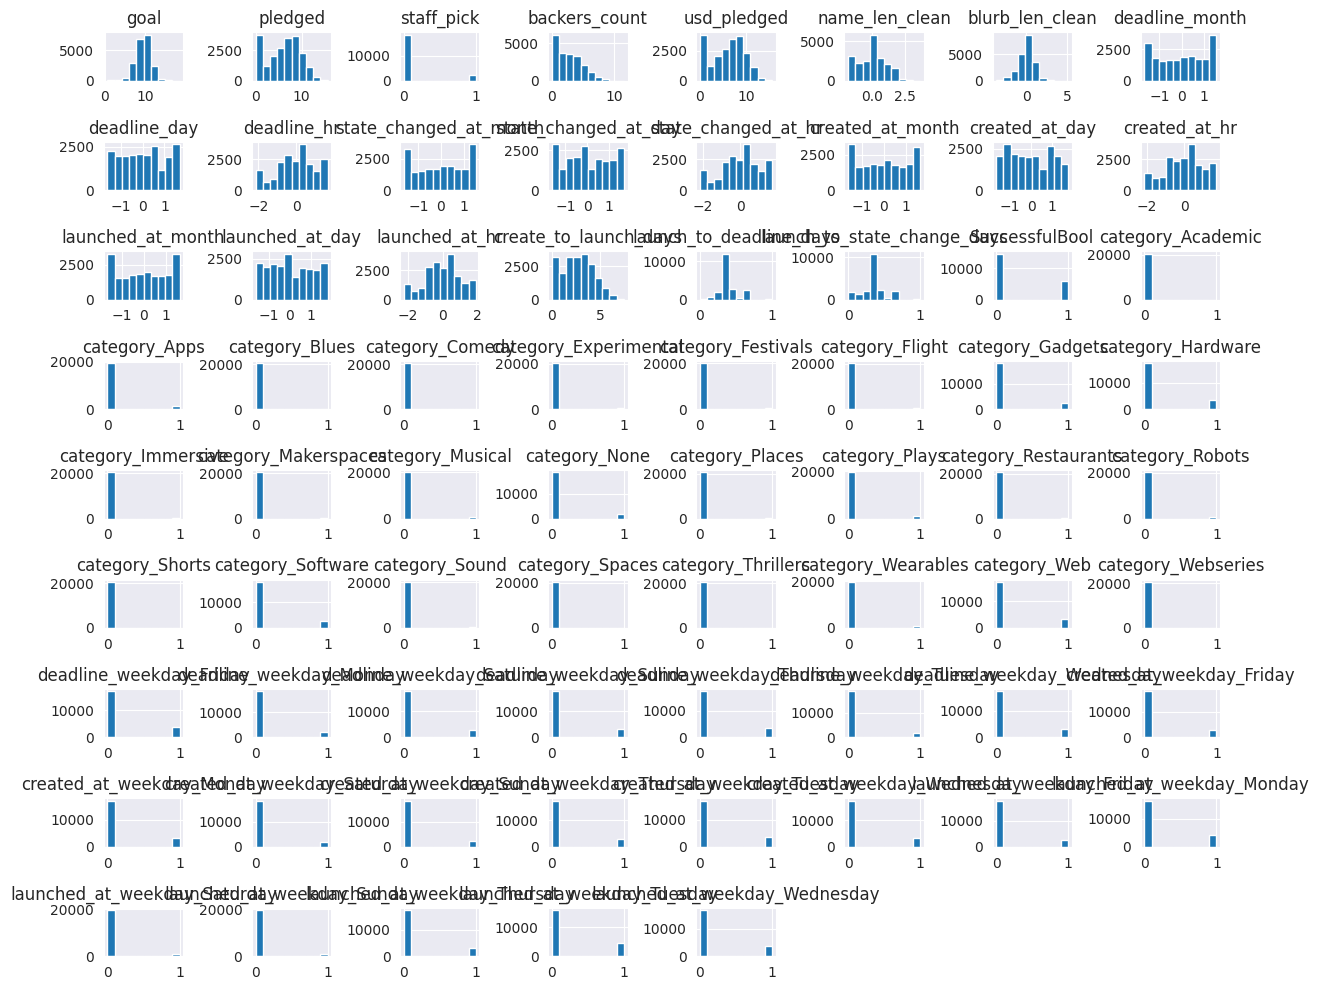

                                   goal   pledged  backers_count  usd_pledged  \
goal                           1.000000  0.124508       0.086695     0.110135   
pledged                        0.124508  1.000000       0.923833     0.996626   
backers_count                  0.086695  0.923833       1.000000     0.926659   
usd_pledged                    0.110135  0.996626       0.926659     1.000000   
name_len_clean                 0.067497  0.293642       0.279944     0.293808   
...                                 ...       ...            ...          ...   
launched_at_weekday_Thursday   0.001326 -0.015169      -0.015243    -0.014968   
launched_at_weekday_Tuesday    0.018767  0.060892       0.071345     0.060832   
launched_at_weekday_Wednesday  0.025505  0.010997       0.011825     0.011076   
staff_pick                     0.084536  0.385184       0.449192     0.387127   
SuccessfulBool                -0.258953  0.585964       0.653987     0.590969   

                           

<Figure size 640x480 with 0 Axes>

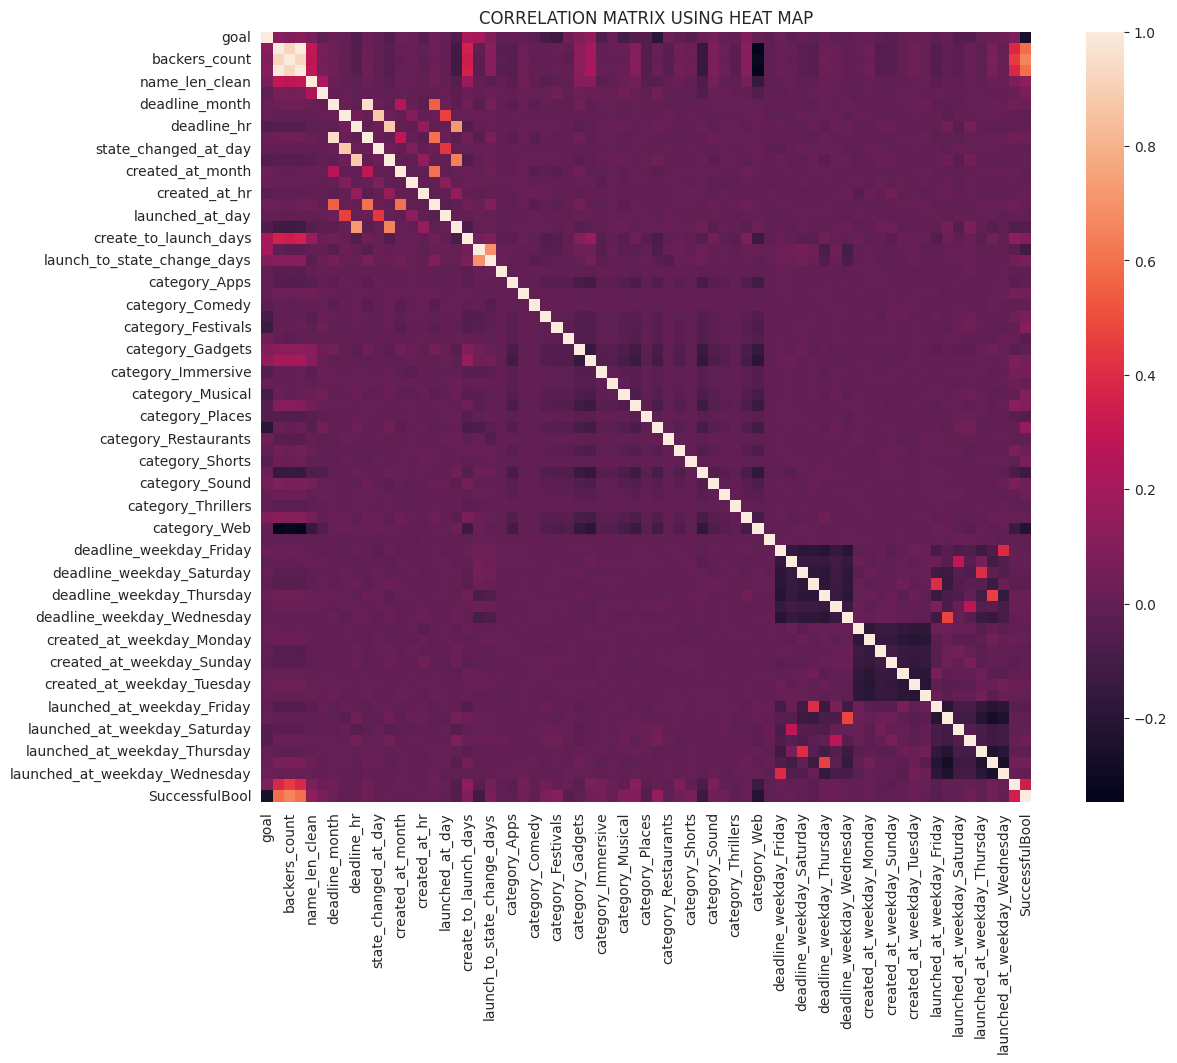

<Figure size 640x480 with 0 Axes>

In [12]:
# Check the data again
data_info(kickstarter)

### We need to make a 'success' classifier, so lets take a look at the definition of success in the data

In [13]:
# Compare 'state' and 'SuccessfulBool' to see if they are the same
print(ks_data['state'].unique())
print(ks_data['SuccessfulBool'].unique())
print(ks_data['state'].value_counts())
print(ks_data['SuccessfulBool'].value_counts())
# Make a table where the rows are 0/1 for SuccessfulBool and the columns are the states
print(ks_data.groupby(['SuccessfulBool', 'state']).size().unstack())

# Show the distribution of 'pledged/goal' to see if we can make a column called 'got_funded'
temp_data = ks_data.copy()

# confirm they're both numbers
print(temp_data['pledged'].dtype)
print(temp_data['goal'].dtype)

# show the count where pledged > goal
print(f'{temp_data[temp_data['pledged'] > temp_data['goal']].shape[0]} projects got funded')

# Create got_funded column and show the histogram
temp_data['got_funded'] = temp_data['pledged'] / temp_data['goal']

# Describe the column
print(temp_data['got_funded'].describe())

# Get count of SuccessfulBool
print(temp_data['SuccessfulBool'].value_counts())
# Shows the same thing

# using kickstarter data, show some good plots of features vs SuccessfulBool

def plot_feature_vs_success(data, feature):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data[data['SuccessfulBool'] == 1][feature], bins=30, kde=True, color='green', label='Successful')
    sns.histplot(data[data['SuccessfulBool'] == 0][feature], bins=30, kde=True, color='red', label='Failed')
    plt.title(f'{feature} vs SuccessfulBool')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.boxplot(x=data['SuccessfulBool'], y=data[feature])
    plt.title(f'{feature} vs SuccessfulBool')
    plt.xlabel('SuccessfulBool')
    plt.ylabel(feature)

    plt.tight_layout()
    plt.show()

# Show the features that are not categorical
for feature in kickstarter.columns:
    if DONT_RUN_LONG_CELLS:
        break
    if feature not in ['state', 'SuccessfulBool', 'category', 'currency', 'staff_pick']:
        plot_feature_vs_success(kickstarter, feature)

['failed' 'canceled' 'successful' 'live' 'suspended']
[0 1]
state
failed        11416
successful     6018
canceled       2460
live            508
suspended       230
Name: count, dtype: int64
SuccessfulBool
0    14614
1     6018
Name: count, dtype: int64
state           canceled   failed   live  successful  suspended
SuccessfulBool                                                 
0                 2460.0  11416.0  508.0         NaN      230.0
1                    NaN      NaN    NaN      6018.0        NaN
float64
float64
6009 projects got funded
count    20632.000000
mean         3.232088
std        177.318223
min          0.000000
25%          0.001500
50%          0.065439
75%          1.030000
max      22603.000000
Name: got_funded, dtype: float64
SuccessfulBool
0    14614
1     6018
Name: count, dtype: int64


### Because `state` captures the same information as `SuccessfulBool`, we can drop it
### and because `got_funded` and `pledged` offer information obtained at the end of the campaign, we should drop them as well

In [14]:
kickstarter = kickstarter.drop(columns=['state', 'pledged', 'usd_pledged'])
kickstarter['name_len_clean'] = kickstarter['name_len_clean'].astype(int)
kickstarter['blurb_len_clean'] = kickstarter['blurb_len_clean'].astype(int)

In [15]:
kickstarter = kickstarter.sample(frac=1, random_state=42).reset_index(drop=True)

X = kickstarter.copy()
Y1 = kickstarter['SuccessfulBool']
X = X.drop(columns=['SuccessfulBool'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, Y1, test_size=0.2, random_state=42, stratify=Y1)

# Part 2: Models (tuning and final models)

### Model 1: Random Forest Classifier

10 features: R² = 0.7299
Selected features: ['backers_count', 'goal', 'launch_to_state_change_days', 'create_to_launch_days', 'created_at_day', 'launch_to_deadline_days', 'created_at_hr', 'launched_at_day', 'launched_at_hr', 'state_changed_at_day']
20 features: R² = 0.7366
Selected features: ['backers_count', 'goal', 'launch_to_state_change_days', 'create_to_launch_days', 'created_at_day', 'launch_to_deadline_days', 'created_at_hr', 'launched_at_day', 'launched_at_hr', 'state_changed_at_day', 'deadline_day', 'created_at_month', 'state_changed_at_hr', 'deadline_hr', 'launched_at_month', 'blurb_len_clean', 'deadline_month', 'state_changed_at_month', 'category_Gadgets', 'category_Software']
30 features: R² = 0.7433
Selected features: ['backers_count', 'goal', 'launch_to_state_change_days', 'create_to_launch_days', 'created_at_day', 'launch_to_deadline_days', 'created_at_hr', 'launched_at_day', 'launched_at_hr', 'state_changed_at_day', 'deadline_day', 'created_at_month', 'state_changed_at_

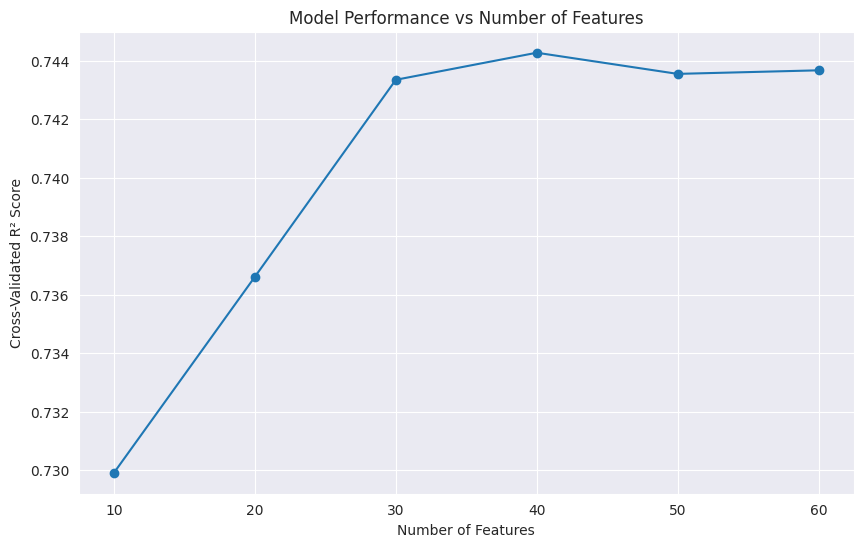


Optimal number of features: 40
Selected features: ['backers_count', 'goal', 'launch_to_state_change_days', 'create_to_launch_days', 'created_at_day', 'launch_to_deadline_days', 'created_at_hr', 'launched_at_day', 'launched_at_hr', 'state_changed_at_day', 'deadline_day', 'created_at_month', 'state_changed_at_hr', 'deadline_hr', 'launched_at_month', 'blurb_len_clean', 'deadline_month', 'state_changed_at_month', 'category_Gadgets', 'category_Software', 'name_len_clean', 'category_Musical', 'category_Hardware', 'category_None', 'category_Apps', 'category_Web', 'created_at_weekday_Friday', 'deadline_weekday_Thursday', 'created_at_weekday_Wednesday', 'staff_pick', 'created_at_weekday_Monday', 'category_Sound', 'launched_at_weekday_Wednesday', 'created_at_weekday_Saturday', 'category_Plays', 'launched_at_weekday_Tuesday', 'deadline_weekday_Wednesday', 'deadline_weekday_Friday', 'created_at_weekday_Sunday', 'category_Wearables']

Random Forest selected 40 features: ['backers_count', 'goal', '

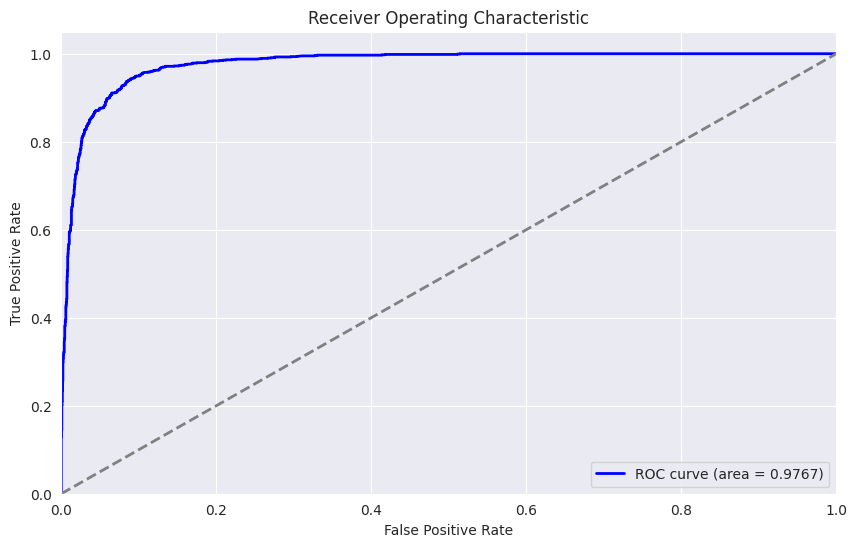

/tmp/ipykernel_4412/432874874.py:188: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  default_samples['param_max_depth'] = default_samples['param_max_depth'].fillna(-1)
/tmp/ipykernel_4412/432874874.py:188: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  default_samples['param_max_depth'] = default_samples['param_max_depth'].fillna(-1)


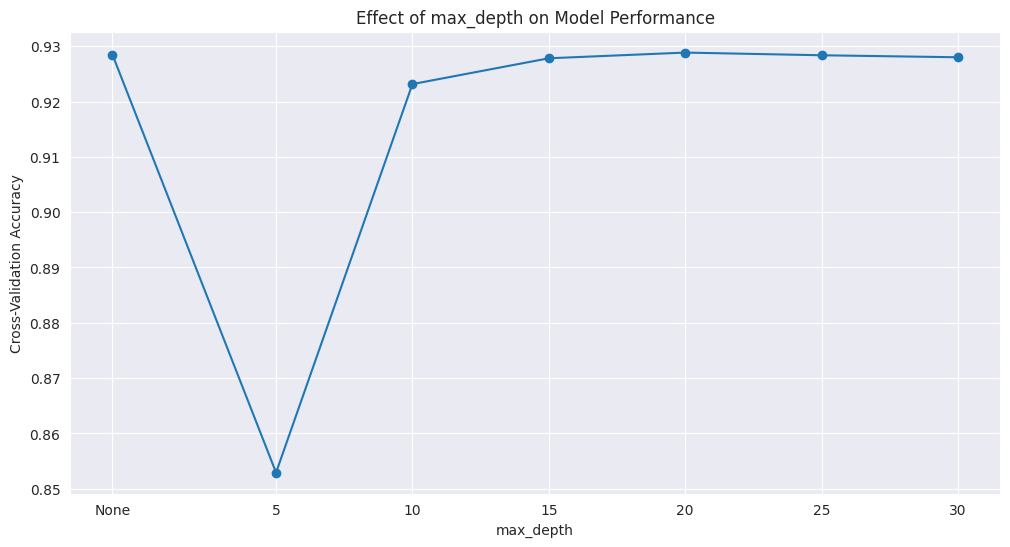

In [16]:
def get_rf_feature_importance(_X_train: DataFrame, _y_train: ndarray, n_features: int = 10) -> tuple:
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(_X_train, _y_train)

    # Get feature importances
    importances = rf.feature_importances_
    indices = argsort(importances)[::-1]

    # Select top n features
    top_features = _X_train.columns[indices[:n_features]].tolist()
    return top_features, indices


def get_rfe_features(_X_train: DataFrame, _y_train: ndarray, n_features: int = 10) -> list:
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    rfe = RFE(estimator=model, n_features_to_select=n_features)
    rfe.fit(_X_train, _y_train)

    # Get selected features
    selected_features = _X_train.columns[rfe.support_].tolist()
    return selected_features

# Method 3: Statistical feature selection
def get_statistical_features(_X_train: DataFrame, _y_train: ndarray, n_features: int = 10) -> list:
    selector = SelectKBest(score_func=f_regression, k=n_features)
    selector.fit(_X_train, _y_train)

    # Get selected features
    selected_mask = selector.get_support()
    selected_features = _X_train.columns[selected_mask].tolist()
    return selected_features

# Get ordered features and indices from Random Forest
top_features, importance_indices = get_rf_feature_importance(X_train, y_train, len(X_train.columns))
ranked_features = X_train.columns[importance_indices].tolist()

# Define range of feature counts to test
feature_counts = [10, 20, 30, 40, 50, 60]
if len(ranked_features) < 30:
    feature_counts = list(range(5, len(ranked_features)+1, 5))

# Test different feature counts
cv_scores = []
for n_features in feature_counts:
    if n_features > len(ranked_features):
        continue

    # Select top n features
    selected_features = ranked_features[:n_features]
    X_selected = X_train[selected_features]

    # Evaluate with cross-validation
    scores = cross_val_score(
        RandomForestRegressor(n_estimators=100, random_state=42),
        X_selected, y_train,
        cv=5, scoring='r2'
    )

    cv_scores.append(scores.mean())
    print(f"{n_features} features: R² = {scores.mean():.4f}")
    print(f"Selected features: {selected_features}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(feature_counts[:len(cv_scores)], cv_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validated R² Score')
plt.title('Model Performance vs Number of Features')
plt.grid(True)
plt.savefig('feature_selection_curve.png')
plt.show()

# Find the optimal number based on the results
optimal_idx = max(range(len(cv_scores)), key=cv_scores.__getitem__)
optimal_n_features = feature_counts[optimal_idx]
print(f"\nOptimal number of features: {optimal_n_features}")
print(f"Selected features: {ranked_features[:optimal_n_features]}")

# For comparison, also get features using RFE and Statistical methods
rfe_features = get_rfe_features(X_train, y_train, optimal_n_features)
stat_features = get_statistical_features(X_train, y_train, optimal_n_features)

print(f"\nRandom Forest selected {optimal_n_features} features: {ranked_features[:optimal_n_features]}")
print(f"RFE selected {optimal_n_features} features: {rfe_features}")
print(f"Statistical selection selected {optimal_n_features} features: {stat_features}")

# Find common features across all methods
common_features = set(ranked_features[:optimal_n_features]) & set(rfe_features) & set(stat_features)
print(f"\nFeatures selected by all methods: {common_features}")

optimal_features = ranked_features[:optimal_n_features]

# Train the model using optimal features
X_train_optimal = X_train[optimal_features]
X_test_optimal = X_test[optimal_features]

# Define parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [None, 5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create base model
base_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Setup Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Perform Grid Search
grid_search.fit(X_train_optimal, y_train)

# Get best parameters and best model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Make predictions with the best model
y_pred = best_rf_model.predict(X_test_optimal)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Feature importance of the final model
feature_importance = best_rf_model.feature_importances_
importance_df = DataFrame({
    'Feature': optimal_features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(importance_df.head(10))  # Show top 10 features

# Calculate cross-validation score for the best model
cv_scores = cross_val_score(
    best_rf_model,
    X[optimal_features], Y1,
    cv=5, scoring='accuracy'
)
print(f"\nCross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Plot ROC curve
y_pred_proba = best_rf_model.predict_proba(X_test_optimal)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2,
         label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Visualize hyperparameter tuning results
results = DataFrame(grid_search.cv_results_)

# Plot accuracy for different max_depth values
plt.figure(figsize=(12, 6))

# Filter results for default min_samples values
default_samples = results[(results['param_min_samples_split'] == 2) &
                         (results['param_min_samples_leaf'] == 1)]

# Convert None to -1 for plotting purposes
default_samples['param_max_depth'] = default_samples['param_max_depth'].fillna(-1)

# Sort by max_depth for proper x-axis order
default_samples = default_samples.sort_values('param_max_depth')

plt.plot(default_samples['param_max_depth'],
         default_samples['mean_test_score'],
         marker='o', linestyle='-')

# Replace -1 with "None" in xticks
x_ticks = default_samples['param_max_depth'].unique()
x_labels = [str(int(x)) if x > 0 else "None" for x in x_ticks]

plt.xticks(x_ticks, x_labels)
plt.xlabel('max_depth')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Effect of max_depth on Model Performance')
plt.grid(True)
plt.show()

final_models.append(('Random Forest', best_rf_model))

### Model 2: AdaBoost

Best parameters: learning_rate=0.1, max_depth=5
Best accuracy: 0.9326


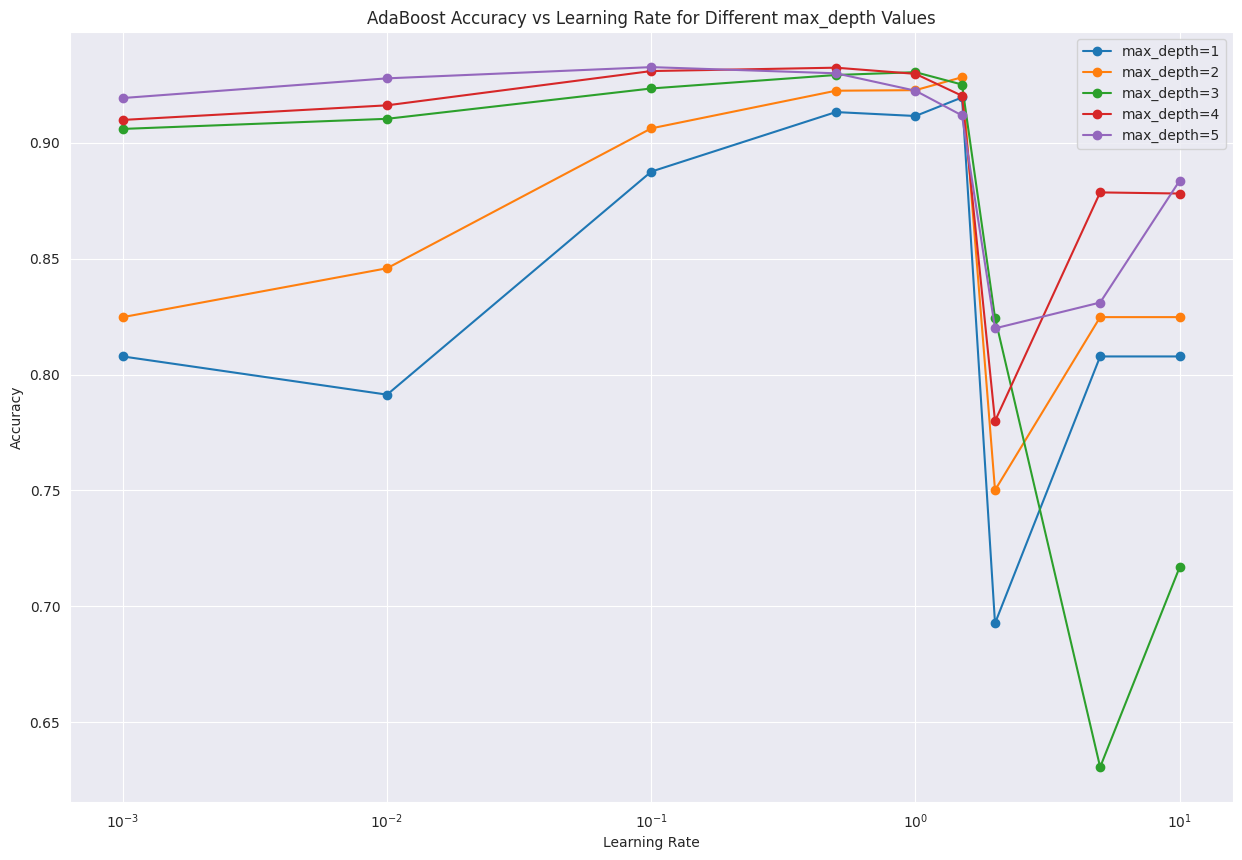

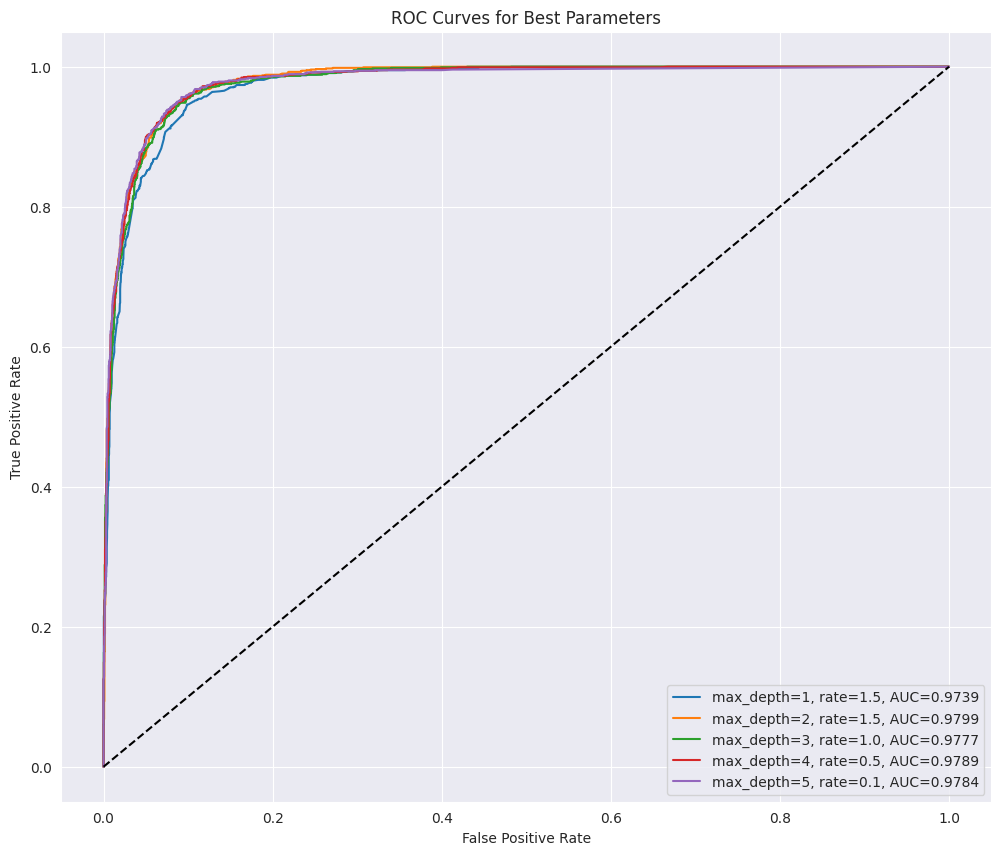

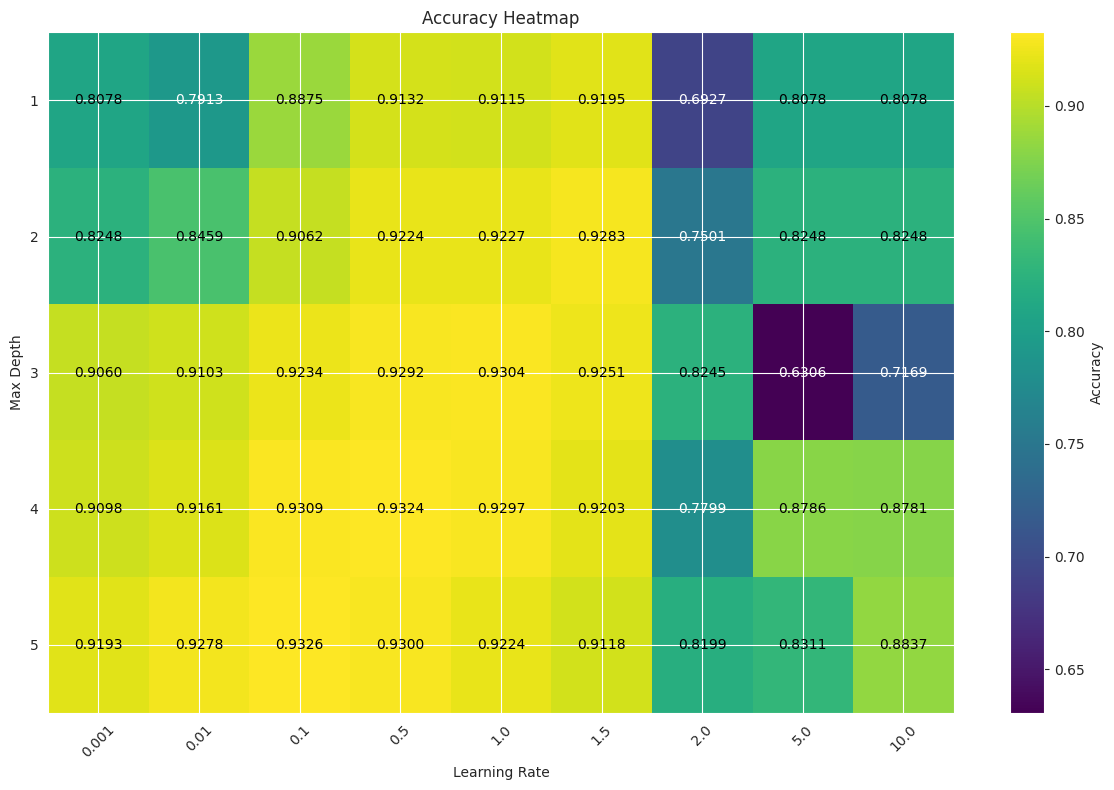

In [19]:
# Parameters to tune
rates = [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0]
max_depths = [1, 2, 3, 4, 5]

# Initialize tracking variables
results = {}
best_params = {"rate": 0, "depth": 0}
best_accuracy = 0
best_auc = 0

# Perform grid search
for depth in max_depths:
    results[depth] = {"rates": [], "accuracies": [], "aucs": [], "roc_curves": []}
    print(f'Trying max depth {depth}')

    for rate in rates:
        print(f'Trying rate {rate}')
        # Create and train model
        ab_clf = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=depth, random_state=42),
            n_estimators=50,
            learning_rate=rate,
            random_state=42
        )
        ab_clf.fit(X_train, y_train)

        # Get predictions
        ab_y_pred = ab_clf.predict(X_test)
        ab_y_prob = ab_clf.predict_proba(X_test)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, ab_y_pred)
        fpr, tpr, _ = roc_curve(y_test, ab_y_prob)
        auc = roc_auc_score(y_test, ab_y_prob)

        # Store results
        results[depth]["rates"].append(rate)
        results[depth]["accuracies"].append(accuracy)
        results[depth]["aucs"].append(auc)
        results[depth]["roc_curves"].append((fpr, tpr))

        # Update best params if needed
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params["rate"] = rate
            best_params["depth"] = depth

        if auc > best_auc:
            best_auc = auc

# Print results
print(f"Best parameters: learning_rate={best_params['rate']}, max_depth={best_params['depth']}")
print(f"Best accuracy: {best_accuracy:.4f}")

# Visualize accuracy results
plt.figure(figsize=(15, 10))

for depth in max_depths:
    plt.plot(rates, results[depth]["accuracies"], marker='o', label=f'max_depth={depth}')

plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('AdaBoost Accuracy vs Learning Rate for Different max_depth Values')
plt.legend()
plt.grid(True)

# Visualize ROC curves for best parameters for each max_depth
plt.figure(figsize=(12, 10))

for depth in max_depths:
    best_idx = np.argmax(results[depth]["accuracies"])
    best_rate = results[depth]["rates"][best_idx]
    fpr, tpr = results[depth]["roc_curves"][best_idx]
    auc = results[depth]["aucs"][best_idx]
    plt.plot(fpr, tpr, label=f'max_depth={depth}, rate={best_rate}, AUC={auc:.4f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Best Parameters')
plt.legend()

# Create heatmap of accuracies
plt.figure(figsize=(12, 8))
heatmap_data = np.zeros((len(max_depths), len(rates)))

for i, depth in enumerate(max_depths):
    for j, rate in enumerate(rates):
        idx = results[depth]["rates"].index(rate)
        heatmap_data[i, j] = results[depth]["accuracies"][idx]

plt.imshow(heatmap_data, cmap='viridis', aspect='auto')
plt.colorbar(label='Accuracy')
plt.xticks(np.arange(len(rates)), [str(rate) for rate in rates], rotation=45)
plt.yticks(np.arange(len(max_depths)), [str(depth) for depth in max_depths])
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')
plt.title('Accuracy Heatmap')

for i in range(len(max_depths)):
    for j in range(len(rates)):
        plt.text(j, i, f"{heatmap_data[i, j]:.4f}",
                 ha="center", va="center", color="white" if heatmap_data[i, j] < 0.8 else "black")

plt.tight_layout()
plt.show()

ab_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=best_params['depth'], random_state=42),
    n_estimators=500,
    learning_rate=best_params['rate'],
    random_state=42
)
ab_clf.fit(X_train, y_train)
ab_y_prob = ab_clf.predict_proba(X_test)[:, 1]
ab_fpr, ab_tpr, _ = roc_curve(y_test, ab_y_prob)
ab_auc = roc_auc_score(y_test, ab_y_prob)
final_models.append(('AdaBoost', ab_clf))

### Model 3: Bagging

In [ ]:
# Parameters to tune
max_depths = [1, 2, 3, 4, 5, 10, None]  # None means nodes are expanded until all leaves are pure
n_estimators_list = [50, 150, 500]
bootstrap_options = [True, False]
max_samples_list = [0.5, 0.7, 1.0]  # Proportion of samples to draw

# Initialize tracking variables
results = {}
best_params = {
    "max_depth": 0,
    "n_estimators": 0,
    "bootstrap": False,
    "max_samples": 0
}
best_accuracy = 0
best_auc = 0

# Create a dictionary to store all results for visualization
all_results = []

# Perform grid search
for max_depth in max_depths:
    print('*' * 20)
    print(f'Trying max depth {max_depth}')
    for n_estimators in n_estimators_list:
        print(f'Trying {n_estimators=}')
        for bootstrap in bootstrap_options:
            print(f'Trying {bootstrap=}')
            for max_samples in max_samples_list:
                # Skip invalid combinations (max_samples only applicable with bootstrap=True)

                if not bootstrap and max_samples != 1.0:
                    continue
                print(f'Trying {max_samples=}')

                # Create base estimator
                base_estimator = DecisionTreeClassifier(max_depth=max_depth, random_state=42)

                # Create and train model
                bag_clf = BaggingClassifier(
                    base_estimator,
                    n_estimators=n_estimators,
                    bootstrap=bootstrap,
                    max_samples=max_samples if bootstrap else 1.0,
                    random_state=42
                )
                bag_clf.fit(X_train, y_train)

                # Get predictions
                bag_y_pred = bag_clf.predict(X_test)
                bag_y_prob = bag_clf.predict_proba(X_test)[:, 1]

                # Calculate metrics
                accuracy = accuracy_score(y_test, bag_y_pred)
                try:
                    fpr, tpr, _ = roc_curve(y_test, bag_y_prob)
                    auc = roc_auc_score(y_test, bag_y_prob)
                except:
                    fpr, tpr = [0, 1], [0, 1]
                    auc = 0.5

                # Store results
                config = {
                    "max_depth": max_depth,
                    "n_estimators": n_estimators,
                    "bootstrap": bootstrap,
                    "max_samples": max_samples,
                    "accuracy": accuracy,
                    "auc": auc,
                    "roc_curve": (fpr, tpr)
                }
                all_results.append(config)

                # Update best params if needed
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {
                        "max_depth": max_depth,
                        "n_estimators": n_estimators,
                        "bootstrap": bootstrap,
                        "max_samples": max_samples
                    }

                if auc > best_auc:
                    best_auc = auc

# Print best results
print(f"Best parameters:")
print(f"  max_depth: {best_params['max_depth']}")
print(f"  n_estimators: {best_params['n_estimators']}")
print(f"  bootstrap: {best_params['bootstrap']}")
print(f"  max_samples: {best_params['max_samples']}")
print(f"Best accuracy: {best_accuracy:.4f}")

# Visualize effect of max_depth with other parameters fixed
plt.figure(figsize=(15, 10))

# Filter results for bootstrap=True, n_estimators=50, max_samples=1.0
filtered_results = [r for r in all_results
                   if r["bootstrap"] == True and
                      r["n_estimators"] == 50 and
                      r["max_samples"] == 1.0]

# Sort by max_depth for visualization
filtered_results.sort(key=lambda x: str(x["max_depth"]))  # Convert None to string for sorting

depth_values = [r["max_depth"] for r in filtered_results]
depth_labels = [str(d) for d in depth_values]
accuracies = [r["accuracy"] for r in filtered_results]

plt.bar(depth_labels, accuracies)
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Effect of Max Depth on Bagging Classifier Accuracy')
plt.ylim(min(accuracies) - 0.05, max(accuracies) + 0.05)

# Visualize effect of n_estimators
plt.figure(figsize=(15, 10))

# Filter results for bootstrap=True, max_depth=3, max_samples=1.0
filtered_results = [r for r in all_results
                   if r["bootstrap"] == True and
                      r["max_depth"] == 3 and
                      r["max_samples"] == 1.0]

# Sort by n_estimators
filtered_results.sort(key=lambda x: x["n_estimators"])

n_estimators_values = [r["n_estimators"] for r in filtered_results]
accuracies = [r["accuracy"] for r in filtered_results]

plt.plot(n_estimators_values, accuracies, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Effect of Number of Estimators on Bagging Classifier Accuracy')

# Visualize bootstrap vs no bootstrap
plt.figure(figsize=(15, 10))

# Filter results for max_depth=3, n_estimators=50, max_samples=1.0
bootstrap_true = [r for r in all_results
                 if r["max_depth"] == 3 and
                    r["n_estimators"] == 50 and
                    r["max_samples"] == 1.0 and
                    r["bootstrap"] == True]

bootstrap_false = [r for r in all_results
                  if r["max_depth"] == 3 and
                     r["n_estimators"] == 50 and
                     r["max_samples"] == 1.0 and
                     r["bootstrap"] == False]

labels = ['Bootstrap', 'No Bootstrap']
values = [bootstrap_true[0]["accuracy"] if bootstrap_true else 0,
          bootstrap_false[0]["accuracy"] if bootstrap_false else 0]

plt.bar(labels, values)
plt.ylabel('Accuracy')
plt.title('Effect of Bootstrap on Bagging Classifier Accuracy')
plt.ylim(min(values) - 0.05, max(values) + 0.05)

# Visualize effect of max_samples with bootstrap=True
plt.figure(figsize=(15, 10))

# Filter results for bootstrap=True, max_depth=3, n_estimators=50
filtered_results = [r for r in all_results
                   if r["bootstrap"] == True and
                      r["max_depth"] == 3 and
                      r["n_estimators"] == 50]

# Sort by max_samples
filtered_results.sort(key=lambda x: x["max_samples"])

max_samples_values = [r["max_samples"] for r in filtered_results]
accuracies = [r["accuracy"] for r in filtered_results]

plt.plot(max_samples_values, accuracies, marker='o')
plt.xlabel('Max Samples')
plt.ylabel('Accuracy')
plt.title('Effect of Max Samples on Bagging Classifier Accuracy')

# Create a summary of top 10 configurations
all_results.sort(key=lambda x: x["accuracy"], reverse=True)
top_configs = all_results[:10]

plt.figure(figsize=(15, 10))
config_labels = [f"D:{r['max_depth']},N:{r['n_estimators']},\nB:{r['bootstrap']},S:{r['max_samples']}" for r in top_configs]
accuracies = [r["accuracy"] for r in top_configs]

plt.bar(range(len(config_labels)), accuracies)
plt.xticks(range(len(config_labels)), config_labels, rotation=45)
plt.xlabel('Configuration')
plt.ylabel('Accuracy')
plt.title('Top 10 Bagging Classifier Configurations')

# Visualize ROC curves for top 5 configurations
plt.figure(figsize=(12, 10))

for i, config in enumerate(top_configs[:5]):
    fpr, tpr = config["roc_curve"]
    plt.plot(fpr, tpr,
             label=f"D:{config['max_depth']},N:{config['n_estimators']},B:{config['bootstrap']},S:{config['max_samples']}, AUC:{config['auc']:.4f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Top 5 Configurations')
plt.legend()

plt.tight_layout()
plt.show()

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_depth=None, random_state=42),
    n_estimators=500,
    bootstrap=True,
    n_jobs=-1,
    max_samples=0.5,
    random_state=40
)

bag_y_prob = bag_clf.predict_proba(X_test)[:, 1]
bag_fpr, bag_tpr, _ = roc_curve(y_test, bag_y_prob)
bag_auc = roc_auc_score(y_test, bag_y_prob)

### Model 4: Decision Trees

In [ ]:
def evaluate_svc_models(models, X, y):
    results = []
    names = []
    for name, _ in models:
        print(f"Tuning hyperparameters for: {name}")
        kfold = KFold(n_splits=10, shuffle=True, random_state=42)

        if name == 'SVC_RBF':
            param_grid = {
                'C': [0.1, 1, 10],
                'gamma': ['scale', 'auto', 0.01, 0.1]
            }
            model = SVC(kernel='rbf', random_state=42, probability=True)

        elif name == 'SVC_POLY':
            param_grid = {
                'C': [0.1, 1, 10],
                'degree': [2, 3, 4],
                'gamma': ['scale', 'auto']
            }
            model = SVC(kernel='poly', random_state=42, probability=True)

        elif name == 'SVC_LINEAR': # Added
            param_grid = {
                'C': [0.1, 1, 10],
                'tol': [1e-4, 1e-3]
            }
            model = SVC(kernel='linear', random_state=42, probability=True)

        elif name == 'SVC_SIGMOID': # Added
            param_grid = {
                'C': [0.1, 1, 10],
                'gamma': ['scale', 'auto']
            }
            model = SVC(kernel='sigmoid', random_state=42, probability=True)

        else:
            continue

        grid = GridSearchCV(model, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)
        grid.fit(X, y)
        best_model = grid.best_estimator_


        # Best parameters
        print(f"Best params for {name}: {grid.best_params_}")
        print(f"Best CV accuracy: {grid.best_score_:.4f}")

        # F1 Score
        y_pred = cross_val_predict(best_model, X, y, cv=kfold)
        f1 = f1_score(y, y_pred)
        print(f"F1 Score for {name}: {f1:.4f}")

        # ROC Curve
        y_scores = cross_val_predict(best_model, X, y, cv=kfold, method='predict_proba')[:, 1]
        fpr, tpr, _ = roc_curve(y, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

        # Evaluate best estimator using cross_val_score
        cv_results = cross_val_score(best_model, X, y, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)

        print(f"F1 Score: {f1:.4f} | AUC: {roc_auc:.4f}")
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    # Plot results
    fig = plt.figure()
    fig.suptitle('Tuned SVC Model Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results, labels=names)
    ax.set_ylabel('Accuracy')
    plt.show()

# You still pass in model names (the second item is ignored)
models = [('SVC_RBF', None), ('SVC_POLY', None), ('SVC_LINEAR', None), ('SVC_SIGMOID', None)]
evaluate_svc_models(models, X_train, y_train)

### Model 6: Multilayer Perceptron

# Part 3: Display results (from all final models)

In [ ]:
for name, model in final_models:
    print(f"Model: {name}")
    # TODO: Display results for each model